# Using Machine Learning to Forecast Air Quality in Beijing

## 1 - Data Wrangling

### Import Python Packages

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data set

In [0]:
# Data obtained from UCI Repository (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BeijingPM20100101_20151231.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
No                 52584 non-null int64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.2+ MB


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


### Re-index DataFrame and clean up column labels

In [0]:
# Index dataframe using datetime
df.index = pd.to_datetime(df.year*1000000 + df.month*10000 + df.day*100 + df.hour, format='%Y%m%d%H')

In [0]:
# Rename columns to be easily recognizable
df = df.rename(columns={'PM_US Post': 'pm25', 'DEWP': 'dew_point',
                       'HUMI': 'humidity', 'PRES': 'pressure',
                       'TEMP' : 'temp', 'cbwd': 'wind_dir',
                       'Iws': 'wind_speed'})
df = df.copy()

### Find out frequency of NaN per day

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of Days with x Hours of NaN')

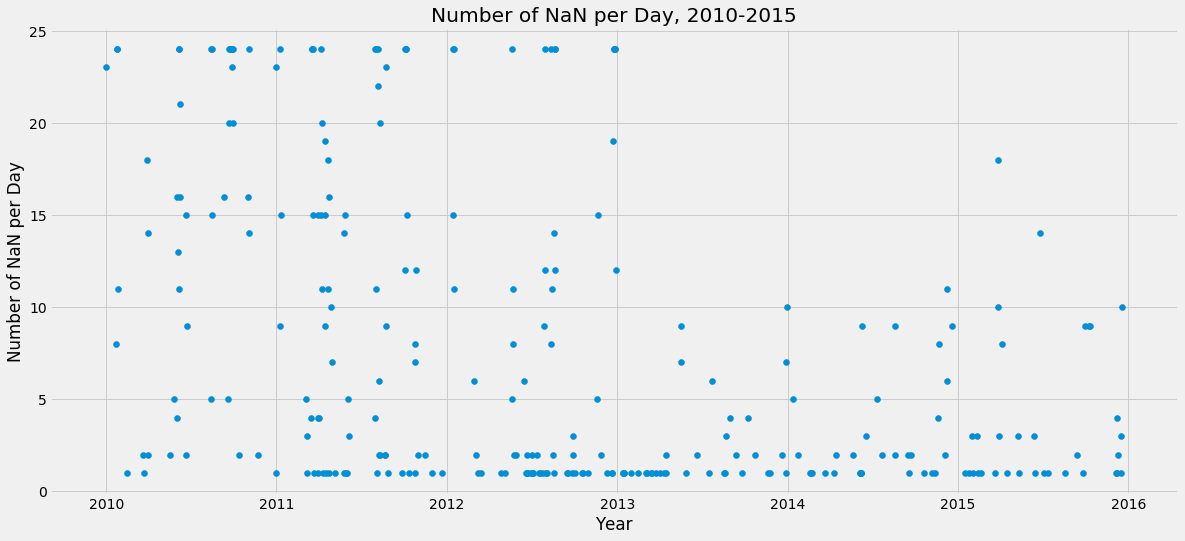

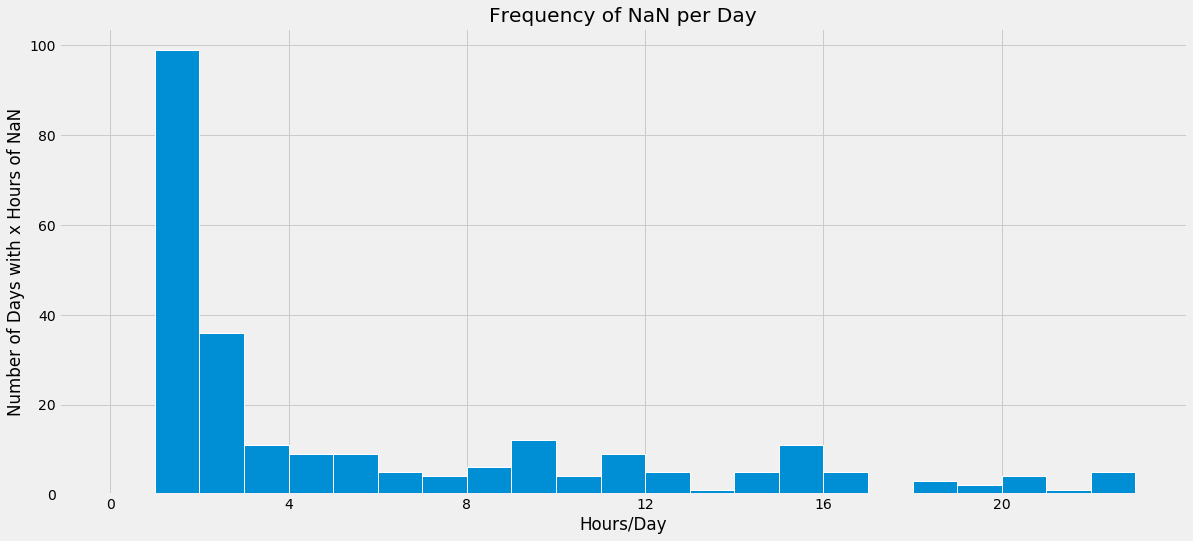

In [0]:
# How frequently do NaN appear each day?

dailyNaN = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN[dailyNaN > 0].index, y = dailyNaN[dailyNaN > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')

plt.figure()
plt.title('Frequency of NaN per Day')
plt.hist(dailyNaN[dailyNaN > 0], bins=range(0,24,1), edgecolor='w', lw=1)
plt.xticks(np.arange(0,24,4))
plt.xlabel('Hours/Day')
plt.ylabel('Number of Days with x Hours of NaN')

### Plot distribution of outages represented by consecutive NaN

In [0]:
# Function consecNaN() constructs a list of the number of hours that the NaN's appear consecutively:
def consecNaN(NaNorNot):
    consecutive = []
    counter = 0
    before = False
    for ii in NaNorNot:
        if ii == True:
            if before == False:
                counter = 1
            else:
                counter += 1
            before = True
        else:
            if before == True:
                consecutive.append(counter)
            before = False
    return consecutive

In [0]:
consecNaN_dist = consecNaN(df.pm25.isnull())
consecNaN_dist_over1 = [ii for ii in consecNaN_dist if ii > 1]

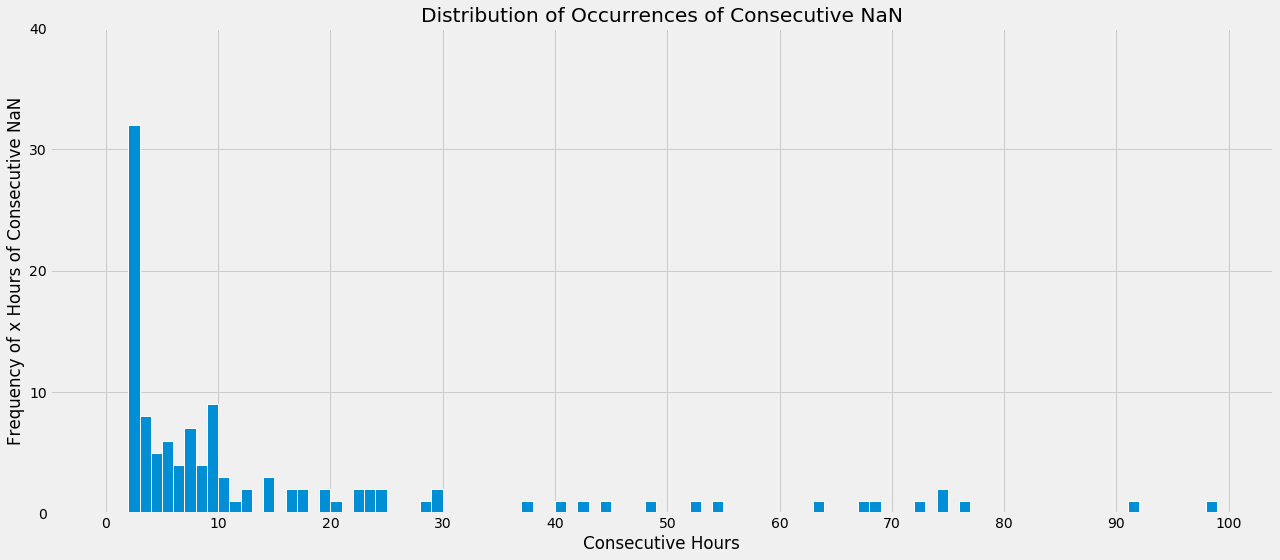

In [0]:
plt.figure()
plt.hist(consecNaN_dist_over1, bins=range(0,100,1), edgecolor='w', lw=1)
plt.title('Distribution of Occurrences of Consecutive NaN')
plt.xticks(np.arange(0,110,10))
plt.xlabel('Consecutive Hours')
plt.ylabel('Frequency of x Hours of Consecutive NaN')
plt.yticks(np.arange(0,50,10))
plt.tight_layout()

### Discard days with more than 2 NaN

In [0]:
# Now, we find the days with more than 2 NaN and remove them

more_than_2hrs = df.pm25.isnull().resample('D').sum() > 2
more_than_2hrs = more_than_2hrs[more_than_2hrs == True]


    


In [0]:
more_than_2hrs.head()

2010-01-01    True
2010-01-23    True
2010-01-24    True
2010-01-25    True
2010-01-26    True
Name: pm25, dtype: bool

In [0]:
df_more_than_2hrs = []

for ii in more_than_2hrs.index:
    df_more_than_2hrs.append(df[str(datetime.date(ii))])

df_more_than_2hrs = pd.concat(df_more_than_2hrs, axis = 1)



In [0]:
# Drop the days with more than 2 hrs of NaN

df = df.drop(df_more_than_2hrs.index)

### Verify that days with more than 2 NaN have been removed

Text(0, 0.5, 'Number of NaN per Day')

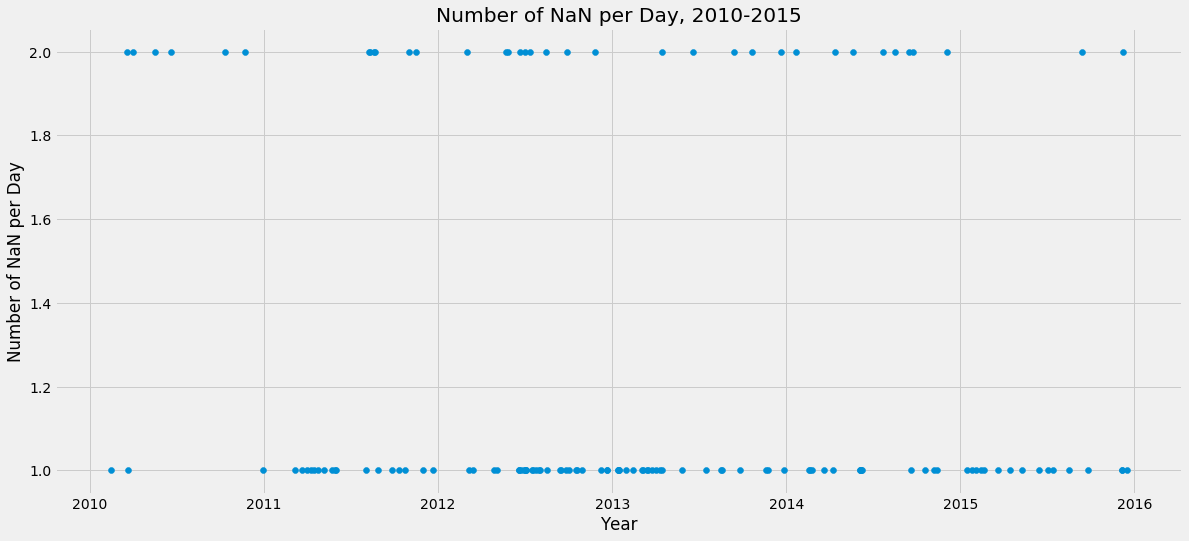

In [0]:
# This plot shows that all days with more than 2 NaN have been removed, as desired

dailyNaN2 = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN2[dailyNaN2 > 0].index, y = dailyNaN2[dailyNaN2 > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')

### Resample DataFrame hourly and daily. Days with missing PM2.5 values are imputed using linear interpolation.

In [0]:
# The data is made available in two formats: hourly and daily.
# After the days with more than 2 NaN were moved, the remaining NaN were resolved with linear interpolation
df_hourly = df.interpolate(method='linear',axis=0)
df_daily = df.resample('D').mean()
df_daily = df_daily.interpolate(method='linear',axis=0)

In [0]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49056 entries, 2010-01-02 00:00:00 to 2015-12-31 23:00:00
Data columns (total 18 columns):
No                 49056 non-null int64
year               49056 non-null int64
month              49056 non-null int64
day                49056 non-null int64
hour               49056 non-null int64
season             49056 non-null int64
PM_Dongsi          25098 non-null float64
PM_Dongsihuan      23968 non-null float64
PM_Nongzhanguan    25098 non-null float64
pm25               49056 non-null float64
dew_point          49056 non-null float64
humidity           49056 non-null float64
pressure           49056 non-null float64
temp               49056 non-null float64
wind_dir           49052 non-null object
wind_speed         49056 non-null float64
precipitation      49056 non-null float64
Iprec              49056 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.1+ MB


In [0]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Freq: D
Data columns (total 17 columns):
No                 2190 non-null float64
year               2190 non-null float64
month              2190 non-null float64
day                2190 non-null float64
hour               2190 non-null float64
season             2190 non-null float64
PM_Dongsi          1079 non-null float64
PM_Dongsihuan      1032 non-null float64
PM_Nongzhanguan    1079 non-null float64
pm25               2190 non-null float64
dew_point          2190 non-null float64
humidity           2190 non-null float64
pressure           2190 non-null float64
temp               2190 non-null float64
wind_speed         2190 non-null float64
precipitation      2190 non-null float64
Iprec              2190 non-null float64
dtypes: float64(17)
memory usage: 308.0 KB


In [0]:
df_hourly.to_csv("df_hourly.csv")
df_daily.to_csv("df_daily.csv")